In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [2]:
msk_20m_path = '/Users/meganmason491/Documents/research/sierra/data/20m_analysis/terrain/tuolumne_msk_20m.asc'
dem_20m_path = '/Users/meganmason491/Documents/research/sierra/data/20m_analysis/terrain/tuolumne_dem_20m.asc'
asp_20m_path = '/Users/meganmason491/Documents/research/sierra/data/20m_analysis/terrain/tuolumne_asp_20m.asc'
slp_20m_path = '/Users/meganmason491/Documents/research/sierra/data/20m_analysis/terrain/tuolumne_slp_20m.asc'

dep_20m_path = '/Users/meganmason491/Documents/research/sierra/data/20m_analysis/ascii/20170129_SUPERsnow_depth_20m.asc' #just one depth image...
years = list(range(2013, 2019))

In [3]:
#open
msk_ = np.loadtxt(msk_20m_path, skiprows=6)
dem_ = np.loadtxt(dem_20m_path, skiprows=6)
asp_ = np.loadtxt(asp_20m_path, skiprows=7) 
slp_ = np.loadtxt(slp_20m_path, skiprows=7) 
dep_ = np.loadtxt(dep_20m_path, skiprows=7) / 10                      #convert mm to cm

In [4]:
#flatten
msk = msk_.flatten()
dem = dem_.flatten()
asp = asp_.flatten()
slp = slp_.flatten()
dep = dep_.flatten()

In [5]:
#filters: (1) Tuolumne Basin, (2) Snow Covered Areas, (3) No Data Values for Aspect, -9999
dem = dem[(msk==1) & (dep>0)]
asp = asp[(msk==1) & (dep>0)]
slp = slp[(msk==1) & (dep>0)] 
dep = dep[(msk==1) & (dep>0)]

In [6]:
#dataframe
d = {'dem': dem, 'asp': asp, 'slp': slp, 'dep': dep}                 #data to be put in df
df_ = pd.DataFrame(d)                                                #create df
df = df_.dropna()                                                    #remove all rows with any NaN's
df.drop(df[df['asp'] < 0].index, inplace=True)                       #remove all -9999 in aspect values (i.e. the lakes, water bodies)
df.head() 

,dem,asp,slp,dep
0,3173.589355,231.494385,2.798378,155.9
1,3174.205078,224.230560,2.318916,74.8
2,3174.610107,277.199219,0.770132,172.3
3,3172.035645,199.983109,3.083293,259.4
4,3172.527100,218.970459,4.072806,199.8


In [7]:
#bin labels
bin_labels = {'0-50': 0, '51-75': 1, '76-100': 2, '101-125': 3, '126-150': 4, '151-200': 5, '200-250': 6, '250+': 7}

#method 1
#bin snow depth to categorical bins
def bin_sd(x):
    if 0 < x <= 50:
        return 0
    elif 50 < x <= 75:
        return 1
    elif 75 < x <= 100:
        return 2
    elif 100 < x <= 125:
        return 3
    elif 125 < x <= 150:
        return 4
    elif 150 < x <= 200:
        return 5
    elif 200 < x <= 250:
        return 6
    elif x >250:
        return 7

df['sd_bin'] = df['dep'].apply(bin_sd)
# df['bin_labels'] = bin_labels

In [8]:
#give label names
labels = ['0-50', '51-75', '76-100', '101-125', '126-150', '151-200', '200-250', '251+']
# df['sd_labels'] = pd.cut(df['dep'], bins=[0, 50, 75, 100, 125, 150, 200, 250, float('Inf')], labels=labels)

In [9]:
df

,dem,asp,slp,dep,sd_bin
0,3173.589355,231.494385,2.798378,155.9,5
1,3174.205078,224.230560,2.318916,74.8,1
2,3174.610107,277.199219,0.770132,172.3,5
3,3172.035645,199.983109,3.083293,259.4,7
4,3172.527100,218.970459,4.072806,199.8,5
...,...,...,...,...,...
2813319,3913.634277,335.636444,27.952894,339.4,7
2813320,3917.750732,9.440651,25.027048,242.0,6
2813321,3969.640625,232.864685,10.684752,3.9,0
2813322,3915.650635,266.069458,23.003454,42.0,0


In [10]:
#drop snow depth....
df = df.drop(['dep'], axis=1)
df

,dem,asp,slp,sd_bin
0,3173.589355,231.494385,2.798378,5
1,3174.205078,224.230560,2.318916,1
2,3174.610107,277.199219,0.770132,5
3,3172.035645,199.983109,3.083293,7
4,3172.527100,218.970459,4.072806,5
...,...,...,...,...
2813319,3913.634277,335.636444,27.952894,7
2813320,3917.750732,9.440651,25.027048,6
2813321,3969.640625,232.864685,10.684752,0
2813322,3915.650635,266.069458,23.003454,0


In [11]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)           #float value to the hundredths place
df.describe()                                                         #summary stats, 50%=median, note Aspect and Slope mins=0, ~2.48 million values in remaining dataset 

,dem,asp,slp,sd_bin
count,2812338.00,2812338.00,2812338.00,2812338.00
mean,2767.51,199.88,19.75,5.43
std,424.24,97.85,12.33,2.34
min,1150.28,0.00,0.00,0.00
25%,2540.03,123.13,9.87,5.00
50%,2824.27,204.47,17.80,7.00
75%,3051.67,286.45,27.92,7.00
max,3984.03,360.00,80.38,7.00


### Random Forest Classifier

In [12]:
# df

In [13]:
X=df[['dem', 'asp', 'slp']] #features
y=df['sd_bin'] #values

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
clf=RandomForestClassifier(n_estimators=100)

In [15]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [16]:
y_pred=clf.predict(X_test)
from sklearn import metrics
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6269109235251309


In [17]:
#feature importance
feature_imp = pd.Series(clf.feature_importances_, index=df.columns[:3]).sort_values(ascending=False)
feature_imp

dem   0.45
slp   0.28
asp   0.27
dtype: float64

No handles with labels found to put in legend.


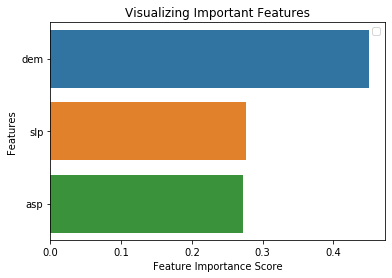

In [18]:
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

In [19]:
break

SyntaxError: 'break' outside loop (<ipython-input-19-6aaf1f276005>, line 4)

### TEST example of Random Forest Classifier

In [ ]:
iris = datasets.load_iris()

In [ ]:
data=pd.DataFrame({
    'sepal length':iris.data[:,0],
    'sepal width':iris.data[:,1],
    'petal length':iris.data[:,2],
    'petal width':iris.data[:,3],
    'species':iris.target
})
data.head()

In [ ]:
X=data[['sepal length', 'sepal width', 'petal length', 'petal width']]
y=data['species']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [ ]:
#feature importance
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)

In [ ]:
feature_imp= pd.Series(clf.feature_importances_, index=iris.feature_names).sort_values(ascending=False)
feature_imp

In [ ]:
iris.feature_names

In [ ]:
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()